# # # # # READ ME PLEASE KIND TEACHER/COURSE ASSISTANT # # # # #

HOW TO USE THIS (AS OF YET):

- Run all cells
- Run a cell where you call FileFinder, e.g. FileFinder(list_of_YKR_IDs, the_folder_where_the_TTM_files_are)
- Run a cell where you call TableJoiner, e.g. TableJoiner(list_of_YKR_IDs, output_folder)
- Run a cell where you call Visualizer, e.g. Visualizer(list_of_YKR_IDs, output_folder, "car", "interactive")

So my problem was that when calling Visualizer(list_of_YKR_IDs, output_folder, "car", "interactive"), the choropleth map does not have any fill color. I have tried many things to fix this, including converting data to geojson for the geo_data -parameter, tinkered with fill_opacity -parameter etc. 

So I don't know what is wrong with the choropleth map. If I could, I would ask you to check the bottom part of my Visualizer function. Thanks in advance!



In [17]:
# Importing modules
import glob
import os
from pathlib import Path
import pandas as pd
import geopandas as gpd
import zipfile
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import folium
import branca

In [77]:
def main():
    
    print("Welcome to AccessViz") 
    YKR_IDs_input = input("Insert a list of YKR ID's (e.g. [1234567, 5787544, 9876543]): ")
    list1 = YKR_IDs_input[1:]
    list2 = [str(x) for x in list1.split()]
    YKR_IDs = []
    for i in list2:
        i = i[:-1]
        YKR_IDs.append(i)
    yes_no = "Accepted answers are yes & no."
    zip_check = input("Do you need to extract the TimeTravelMatrix (TTM) files? yes/no: ")
    if zip_check == "yes":
        zip_name = input("Insert the name of the zip file: ")
        zip_target = input("Insert the name of the target folder: ")
        unzip(zip_name, zip_target)
        print("Please restart AccessViz.")
        #################
    elif zip_check == "no":
        input_folder_name = input("Insert the name of the folder where the TTM files are: ")
        output_folder_name = input("Insert the name of the output folder: ")
        FFF_check = input("TTM files to a text file, yes/no: ")
        if FFF_check == "yes":
            FF_result = FileFinder(YKR_IDs, input_folder_name, to_file=True)# .txt file outputfolderiin?
            print("FFF chekki oli yes boi")
        elif FFF_check == "no":
            FF_result = FileFinder(YKR_IDs, input_folder_name)
            #print("FF:", type(FF_result))
            #print(FF_result)
            print("FFF chekki oli no")
        else:
            print(yes_no)
            
        TJ_result = TableJoiner(YKR_IDs, output_folder_name, FF_result)
        visu = input("Do you want to visualize the results? yes/no: ")
        if visu == "yes":
            visualizer_tm = input("Insert the mode of travel for Visualizer, car/pt/bike/walk: ")
            visualizer_mp = input("Insert the type of map for Visualizer, static/interactive: ")
            Visualizer(YKR_IDs, output_folder_name, visualizer_tm, visualizer_mp, TJ_result)
        elif visu == "no":
            print(f"AccessViz is done, geopackage files can be found in: {output_folder_name}")
            return TJ_result
            ###########################
        else:
            print(yes_no)
    else:
        print(yes_no)
    print("main done")
    
    
    
    
    
    
def FileFinder(YKR_IDs: list, input_folder_name: str, to_file=False):
    """
    Returns a list of travel time matrix filepaths based on a list of YKR ID values
    from a specified input data folder. 

            Parameters:
                    YKR_IDs (list): A list of YKR_ID numbers
                    input_folder_name (str): Name of the input folder
                    to_file (boolean): If True, also returns a text file

            Returns:
                    file_paths (list): A list of filepaths
    """
    # Using assert to make sure input is ok
    assert type(YKR_IDs) == list, "The input of the YKR_ID:s needs to be a list!"
    # Finding the folder from the user's instance
    input_folder = Path(input_folder_name).absolute()
    # Using assert to make sure input folder exists
    assert os.path.isdir(input_folder) == True, "Check the input folder's name!"
    # Creating a global variable of the input folder's name
#   #global global_input_folder_name
#   #global_input_folder_name = input_folder_name
    # Defining counter
    counter = 0
    # Creating an empty list for the filepaths
    file_paths = []
    # Creating a variable for the f-string
    glob_end = "*.txt"
    # Creating a variable for glob
    glob_start = f"{input_folder_name}/**/travel_times_to_ "
    # Creating a list to check for false YKR ID's
    false_names = YKR_IDs.copy()
    # For-looping the user's folders (and subfolders) with glob
    for name in glob.glob(glob_start+glob_end, recursive=True):
        # Finding the YKR ID part of the filepath
        end_txt = name[-11:]
        end = end_txt[:-4]
        # Finding filename of the filepath
        fname = name[-28:]
        # Checking if the YKR ID of the filepath exists in input list
        if end in YKR_IDs:
            # Increasing counter
            counter += 1
            # Informing user of current progress
            print(f"Processing file {fname}. Progress: {counter}/{len(glob.glob(glob_start+glob_end, recursive=True))}")
            # Appending filepath to list
            file_paths.append(name)
            # Removing real YKR ID's from the false YKR ID list
            false_names.remove(end)
        else:
            continue
    # Informing user of false YKR ID's
    for false_ID in false_names:
        print(f"YKR ID number {false_ID} does not exist in folder: {input_folder_name}\nMake sure the YKR ID values in the input list are typed correctly.")
    # Checking for the optional parameter (default is False)
    if to_file == True:
        # Writing the list of filepaths to a text file
        with open("YKR_ID_fps", "w") as output:
            output.write(str(file_paths))
        # Informing the user of the name of the new text file
        print("Wrote the filepaths to file: YKR_ID_fps.txt")
    
    # Returning the list of filepaths
    return file_paths

def TableJoiner(YKR_IDs: list, output_folder_name: str, FF_result):
    """
    Returns spatial layers as geopackage files based on a list of YKR_ID numbers 
    to a specified output folder. 

            Parameters:
                    YKR_IDs (list): A list of YKR ID numbers
                    output_folder_name (str): Name of the output folder
                    FF_result (list): A list of filepaths of the YKR ID numbers ################################################

            Returns:
                    gpkg_files (list): A list of filepaths of the geopackage files
    """
    # Using assert to make sure output_folder is ok
    assert type(output_folder_name) == str, "The output_folder must be a string!"
    assert os.path.isdir(output_folder_name) == True, "Check the output_folder's name!"
    # Creating a global variable of the output folder's name
#    #global global_output_folder_name
#    #global_output_folder_name = output_folder_name
    # Reading the grid file
    grid = gpd.read_file(GridFpFinder())
#    # ASSERT GLOBAL_INPUT_FOLDER_NAME = STR; MAKE SURE TO RUN FILEFINDER FIRST!######## # # # # # !
    filepaths = FF_result

    # Creating an empty list for the file names
    gpkg_files = []
    # For-looping filepaths
    for fp in filepaths:
        # Getting the ID part of the filepath
        id_txt = fp[-11:]
        YKR_ID = id_txt[:-4]
        # Checking if files already exist
        fname = os.path.join(output_folder_name, f"{YKR_ID}.gpkg")
        my_file = Path(fname)
        if my_file.is_file():
            # Appending filepaths to the list
            gpkg_files.append(fname)
            continue
        else:
            # Reading the filepath
            data = pd.read_csv(fp, sep=";")
            # Merging the filepath with grid 
            merge = grid.merge(data, how="right", left_on="YKR_ID", right_on="from_id")
            # Creating a output path for the data with unique name
            output_fp = os.path.join(output_folder_name, f"{YKR_ID}.gpkg")
            # Saving the spatial layer 
            merge.to_file(output_fp, driver="GPKG")
            # Adding the filepaths to a list
            gpkg_files.append(output_fp)
    return gpkg_files

def GridFpFinder():
    """
    Returns the YKR grid filepath from the current directory.
    """
    # Defining flag
    flag = False
    # Getting current directory
    p = Path().absolute()
    # For-looping current directory
    for root, dirs, files in os.walk(p):
        for file in files:
            # Looking for the grid file
            if file.endswith('.shp'):
                if file == "MetropAccess_YKR_grid_EurefFIN.shp":
                    # Creating a filepath of the grid file
                    fullpath = os.path.join(root, file)
                    grid_fp = os.path.abspath(fullpath)
                    # Changing flag value
                    flag = True
    # Checking flag value
    if flag == False:
        # Raising an error
        raise OSError(f"Grid file: MetropAccess_YKR_grid_EurefFIN.shp does not exist in current working directory!\n{p}")
    # Returning the grid's filepath
    return grid_fp


def unzip(zip_file: str, target_folder: str):
    """
    Extracts selected file to a selected directory. 

            Parameters:
                    zip_file (str): Name of the zip file
                    target_dir (str): Name of the target directory

            Returns:
                    None
    """
    assert os.path.isfile(zip_file) == True, "Check the name of the zip file!"
    # Reading zipfile
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        # Extracting zipfile to target folder
        zip_ref.extractall(target_folder)
        # Informing user of the progress
        print(f"File: {zip_file} extracted to: {target_folder}.")
        

def Visualizer(YKR_IDs: list, output_folder: str, travel_mode: str, map_type: str, TJ_result): #############################################
    """
    Returns .png or .html files of maps based on a list of YKR ID values. 

            Parameters:
                    YKR_IDs (list): A list of YKR_ID numbers
                    output_folder (str): Name of the output folder
                    travel_mode (str): Mode of travel. Accepted modes are:
                                        - "car"
                                        - "pt"
                                        - "bike"
                                        - "walk"
                    map_type (str): Type of map. Accepted types are:
                                        - "static"
                                        - "interactive"

            Returns:
                    None
    """
    # Getting the filepaths to the geopackage files
    #gpkg_fps = TableJoiner(YKR_IDs, output_folder)
    gpkg_fps = TJ_result
    # For-looping the files
    for fp in gpkg_fps:
        # Getting the YKR ID number
        name = fp[:-5]
        YKR_ID = name[-7:]
        # Reading the data
        data = gpd.read_file(fp)
        # Changing CRS
        data = data.to_crs(epsg=3857)
        # Checking map_type
        if map_type == "static":
            static_mapper(travel_mode, data, YKR_ID, output_folder)
            break
        elif map_type == "interactive":
            interactive_mapper(travel_mode, data, YKR_ID, output_folder)
            break
        else:
            raise SyntaxError("Check the spelling of map_type parameter!")
                
def static_mapper(tm, data, YKR_ID, output_folder):
    # Checking travel mode
    if tm == "car":
        variable = "car_r_t"
        # Creating unique credits
        credits = f"Travel time data to YKR ID {YKR_ID} by car in rush hour by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    elif tm == "pt":
        variable = "pt_r_t"
        # Creating unique credits
        credits = f"Travel time data to YKR ID {YKR_ID} by pt in rush hour by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    elif tm == "bike":
        variable = "bike_s_t"
        # Creating unique credits
        credits = f"Travel time data to YKR ID {YKR_ID} by slow cycling by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    elif tm == "walk":
        variable = "walk_t"
        # Creating unique credits
        credits = f"Travel time data to YKR ID {YKR_ID} on foot by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    else:
        #print("Check the spelling of travel_mode parameter!")
        raise SyntaxError("Check the spelling of travel_mode parameter!")
    # Saving the destination square 
    destination_square = data.loc[data["from_id"] == data["to_id"]]
    # Dealing with no data values
    data = data.loc[data[variable] > -1]
    # Plotting the data
    fig, ax = plt.subplots(figsize=(12, 8))
    if tm == "walk":
        # Changing the unit of time to hours
        data["walk_h_t"] = data["walk_t"] / 60 
        # Plotting the data
        data.plot(ax=ax,
              column="walk_h_t",
              cmap="RdYlBu",
              linewidth=0,
              scheme="quantiles",
              k=9,
              alpha=0.6,
              legend=True)
        # Legend in hours
        ax.get_legend().set_title("Travel time (hour)")
    else:
        # Plotting the data
        data.plot(ax=ax,
                  column=variable,
                  cmap="RdYlBu",
                  linewidth=0,
                  scheme="quantiles",
                  k=9,
                  alpha=0.6,
                  legend=True)
        # Legend in minutes
        ax.get_legend().set_title("Travel time (min)")
    # Plotting the destination square
    destination_square.plot(ax=ax,
                      color="black",
                      linewidth=0,
                      alpha=0.8)
    # Adjusting legend
    ax.get_legend().set_bbox_to_anchor((1.24, 1))

    # Adding basemap
    ctx.add_basemap(ax, 
                    source=ctx.providers.OpenStreetMap.Mapnik,
                    attribution=credits)
    # Removing axis
    plt.axis("off")
    # Creating a output path for the map with unique name
    outfp = os.path.join(output_folder, f"{variable}_to_{YKR_ID}_static_map.png")
    # Saving figure
    plt.savefig(outfp, dpi=300)

def interactive_mapper(tm, data, YKR_ID, output_folder):
    # Checking travel mode
    if tm == "car":
        variable = "car_r_t"
        credits = f"Travel time data to YKR ID {YKR_ID} by car in rush hour by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    elif tm == "pt":
        variable = "pt_r_t"
        credits = f"Travel time data to YKR ID {YKR_ID} by pt in rush hour by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    elif tm == "bike":
        variable = "bike_s_t"
        credits = f"Travel time data to YKR ID {YKR_ID} by slow cycling by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    elif tm == "walk":
        variable = "walk_t"
        credits = f"Travel time data to YKR ID {YKR_ID} on foot by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    else:
        raise SyntaxError("Check the spelling of travel_mode parameter!")
    # Saving the destination square 
    data[variable].loc[data["from_id"] == data["to_id"]] = 0
    # Dealing with no data values
    data = data.loc[data[variable] > -1]
    # Subsetting data
    data = data[["from_id", variable, "geometry"]]
    # Creating the map instance
    m = folium.Map(location=[60.25, 24.8], zoom_start=10, control_scale=True)
    if tm == "walk":
        # Changing the unit of time to hours
        data["walk_h_t"] = data[variable] / 60
        # Setting colorscale
        colorscale = branca.colormap.linear.RdYlBu_05.to_step(data = data["walk_h_t"], n = 9, method = 'quantiles')
        # Setting caption
        colorscale.caption = f"Travel time (hour)"
        # Defining style so the destination YKR ID square is black
        my_style = lambda x: {'fillColor':'black' if
                    x['properties']['from_id']== int(YKR_ID) else
                    colorscale(x['properties']["walk_h_t"]), 'weight':0, 
                             "fillOpacity": 0.9,}
        # Defining tooltip
        my_tooltip = folium.features.GeoJsonTooltip(fields=['from_id', "walk_h_t"],
                                                    aliases = ['YKR ID:', "Travel time (hour):"],
                                                    labels=True,
                                                    sticky=False)
        # Creating the choropleth map
        folium.features.GeoJson(data,  
                                name='Labels',
                                style_function=my_style,
                                tooltip=my_tooltip                                             
        ).add_to(m)
    else:
        # Setting colorscale
        colorscale = branca.colormap.linear.RdYlBu_05.to_step(data = data[variable], n = 9, method = 'quantiles')
        # Setting caption
        colorscale.caption = f"Travel time (min)"
        # Defining style so the destination YKR ID square is black
        my_style = lambda x: {'fillColor':'black' if
                    x['properties']['from_id']== int(YKR_ID) else
                    colorscale(x['properties'][variable]), 'weight':0, 
                             "fillOpacity": 0.9,}
        # Defining tooltip
        my_tooltip = folium.features.GeoJsonTooltip(fields=['from_id', variable],
                                                    aliases = ['YKR ID:', "Travel time (min):"],
                                                    labels=True,
                                                    sticky=False)
        # Creating the choropleth map
        folium.features.GeoJson(data,  
                                name='Grid',
                                style_function=my_style,
                                tooltip=my_tooltip                                             
        ).add_to(m)
    # Adding the colormap
    m.add_child(colorscale)
    # Adding layer control
    folium.LayerControl().add_to(m)
    title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(credits) 
    m.get_root().html.add_child(folium.Element(title_html))
    # Creating a output path for the map with unique name
    outfp = os.path.join(output_folder, f"{variable}_to_{YKR_ID}_map.html")
    # Saving the map
    m.save(outfp)

    


Welcome to AccessViz


Insert a list of YKR ID's (e.g. [1234567, 5787544, 9876543]):  [5787544, 5787545, 5787546, 5787547, 5787548, 5787549, 5787550, 1234567, 5990000, 5990001, 5990002]
Do you need to extract the TimeTravelMatrix (TTM) files? yes/no:  no
Insert the name of the folder where the TTM files are:  input_data
Insert the name of the output folder:  output_folder
TTM files to a text file, yes/no:  no


Processing file travel_times_to_ 5787544.txt. Progress: 1/10
Processing file travel_times_to_ 5787545.txt. Progress: 2/10
Processing file travel_times_to_ 5787546.txt. Progress: 3/10
Processing file travel_times_to_ 5787547.txt. Progress: 4/10
Processing file travel_times_to_ 5787548.txt. Progress: 5/10
Processing file travel_times_to_ 5787549.txt. Progress: 6/10
Processing file travel_times_to_ 5787550.txt. Progress: 7/10
Processing file travel_times_to_ 5990000.txt. Progress: 8/10
Processing file travel_times_to_ 5990001.txt. Progress: 9/10
Processing file travel_times_to_ 5990002.txt. Progress: 10/10
YKR ID number 1234567 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
FFF chekki oli no


Do you want to visualize the results? yes/no:  yes
Insert the mode of travel for Visualizer, car/pt/bike/walk:  bike
Insert the type of map for Visualizer, static/interactive:  static


main done


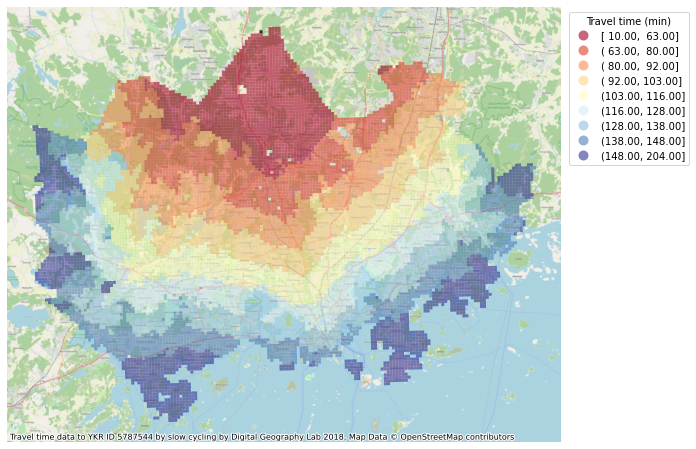

In [78]:
# [5787544, 5787545, 5787546, 5787547, 5787548, 5787549, 5787550, 1234567, 5990000, 5990001, 5990002]
main()

In [50]:
ff = FileFinder([5787544, 5787545, 5787546, 5787547, 5787548, 5787549, 5787550, 1234567, 5990000, 5990001, 5990002], "input_data")

YKR ID number 5787544 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
YKR ID number 5787545 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
YKR ID number 5787546 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
YKR ID number 5787547 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
YKR ID number 5787548 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
YKR ID number 5787549 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
YKR ID number 5787550 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
YKR ID number 1234567 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed cor

[]

In [46]:
# Defining FileFinder
def FileFinder2(YKR_IDs: list, input_folder_name: str, to_file=False):
    """
    Returns a list of travel time matrix filepaths based on a list of YKR ID values
    from a specified input data folder. 

            Parameters:
                    YKR_IDs (list): A list of YKR_ID numbers
                    input_folder_name (str): Name of the input folder
                    to_file (boolean): If True, also returns a text file

            Returns:
                    file_paths (list): A list of filepaths
    """
    # Using assert to make sure input is ok
    assert type(YKR_IDs) == list, "The input of the YKR_ID:s needs to be a list!"
    # Finding the folder from the user's instance
    input_folder = Path(input_folder_name).absolute()
    # Using assert to make sure input folder exists
    assert os.path.isdir(input_folder) == True, "Check the input folder's name!"
    # Creating a global variable of the input folder's name
    global global_input_folder_name
    global_input_folder_name = input_folder_name
    # Defining counter
    counter = 0
    # Creating an empty list for the filepaths
    file_paths = []
    # Creating a variable for the f-string
    glob_end = "*.txt"
    # Creating a variable for glob
    glob_start = f"{input_folder_name}/**/travel_times_to_ "
    # Creating a list to check for false YKR ID's
    false_names = YKR_IDs.copy()
    # For-looping the user's folders (and subfolders) with glob
    for name in glob.glob(glob_start+glob_end, recursive=True):
        # Finding the YKR ID part of the filepath
        end_txt = name[-11:]
        end = end_txt[:-4]
        # Finding filename of the filepath
        fname = name[-28:]
        # Checking if the YKR ID of the filepath exists in input list
        if end in YKR_IDs:
            # Increasing counter
            counter += 1
            # Informing user of current progress
            print(f"Processing file {fname}. Progress: {counter}/{len(glob.glob(glob_start+glob_end, recursive=True))}")
            # Appending filepath to list
            file_paths.append(name)
            # Removing real YKR ID's from the false YKR ID list
            false_names.remove(end)
        else:
            continue
    # Informing user of false YKR ID's
    for false_ID in false_names:
        print(f"YKR ID number {false_ID} does not exist in folder: {input_folder_name}\nMake sure the YKR ID values in the input list are typed correctly.")
    # Checking for the optional parameter (default is False)
    if to_file == True:
        # Writing the list of filepaths to a text file
        with open("YKR_ID_fps", "w") as output:
            output.write(str(file_paths))
        # Informing the user of the name of the new text file
        print("Wrote the filepaths to file: YKR_ID_fps.txt")
    # Returning the list of filepaths
    return file_paths

In [6]:
# Testing the FileFinder
FileFinder(lista, "input_data")
#print(FileFinder(lista, "input_data"))

Processing file travel_times_to_ 5787544.txt. Progress: 1/10
Processing file travel_times_to_ 5787545.txt. Progress: 2/10
Processing file travel_times_to_ 5787546.txt. Progress: 3/10
Processing file travel_times_to_ 5787547.txt. Progress: 4/10
Processing file travel_times_to_ 5787548.txt. Progress: 5/10
Processing file travel_times_to_ 5787549.txt. Progress: 6/10
Processing file travel_times_to_ 5787550.txt. Progress: 7/10
Processing file travel_times_to_ 5990000.txt. Progress: 8/10
Processing file travel_times_to_ 5990001.txt. Progress: 9/10
Processing file travel_times_to_ 5990002.txt. Progress: 10/10
YKR ID number 1234567 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.


['input_data\\travel_times_to_ 5787544.txt',
 'input_data\\travel_times_to_ 5787545.txt',
 'input_data\\travel_times_to_ 5787546.txt',
 'input_data\\travel_times_to_ 5787547.txt',
 'input_data\\travel_times_to_ 5787548.txt',
 'input_data\\travel_times_to_ 5787549.txt',
 'input_data\\travel_times_to_ 5787550.txt',
 'input_data\\sub_folder\\travel_times_to_ 5990000.txt',
 'input_data\\sub_folder\\travel_times_to_ 5990001.txt',
 'input_data\\sub_folder\\travel_times_to_ 5990002.txt']

In [7]:
#data = pd.read_csv(FileFinder(lista, "input_data")[8], sep=";")
#data

Processing file travel_times_to_ 5787544.txt. Progress: 1/10
Processing file travel_times_to_ 5787545.txt. Progress: 2/10
Processing file travel_times_to_ 5787546.txt. Progress: 3/10
Processing file travel_times_to_ 5787547.txt. Progress: 4/10
Processing file travel_times_to_ 5787548.txt. Progress: 5/10
Processing file travel_times_to_ 5787549.txt. Progress: 6/10
Processing file travel_times_to_ 5787550.txt. Progress: 7/10
Processing file travel_times_to_ 5990000.txt. Progress: 8/10
Processing file travel_times_to_ 5990001.txt. Progress: 9/10
Processing file travel_times_to_ 5990002.txt. Progress: 10/10
YKR ID number 1234567 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.


,from_id,to_id,walk_t,walk_d,bike_s_t,bike_f_t,bike_d,pt_r_tt,pt_r_t,pt_r_d,pt_m_tt,pt_m_t,pt_m_d,car_r_t,car_r_d,car_m_t,car_m_d,car_sl_t
0,5785640,5990001,583,40784,178,113,39558,191,171,45848,208,178,45848,82,46868,71,46969,42
1,5785641,5990001,545,38168,175,111,36953,201,174,46054,214,176,46054,82,47079,71,47180,42
2,5785642,5990001,546,38247,175,111,36953,205,175,46171,214,177,46171,82,46480,71,44805,42
3,5785643,5990001,551,38540,171,108,38261,215,179,46464,214,181,46464,82,48363,71,48675,43
4,5787544,5990001,576,40294,175,111,39018,189,164,45358,198,171,45358,81,46442,70,46543,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13226,6016698,5990001,511,35755,166,105,35792,147,124,38723,140,123,38723,83,39030,72,39001,43
13227,6016699,5990001,513,35882,165,105,35769,147,126,38850,142,125,38850,83,38717,72,38689,43
13228,6018252,5990001,518,36253,169,107,36308,153,131,39221,147,130,39221,85,-1,73,-1,44
13229,6018253,5990001,516,36112,168,106,36070,149,129,39080,142,128,39080,84,39207,72,39178,44


In [126]:
# A test list for the FileFinder
lista = str(["5787544", "5787545", "5787546", "5787547", "5787548", "5787549", "5787550", "1234567", "5990000", "5990001", "5990002"])
print(type(lista))
lista1 = lista[1:]
lista2 = lista1[:-1]
print(lista2)
print(type(lista2))
finalista = [int(x) for x in lista.split()]
print(finalista)
print(type(finalista))

<class 'str'>
'5787544', '5787545', '5787546', '5787547', '5787548', '5787549', '5787550', '1234567', '5990000', '5990001', '5990002'
<class 'str'>


ValueError: invalid literal for int() with base 10: "['5787544',"

In [14]:
#lista = str(["5787544", "5787545", "5787546", "5787547", "5787548", "5787549", "5787550", "1234567", "5990000", "5990001", "5990002"])
#lista0 = lista[1:-1]
#print(lista0)
#print(type(lista0))

#finalista0 = [str(x) for x in lista0.split()]
#print(finalista0)
#print(type(finalista0))

#atsil = str([5787544, 5787545, 5787546, 5787547, 5787548, 5787549, 5787550, 1234567, 5990000, 5990001, 5990002])
atsil = input("lista: ")
atsil0 = atsil[1:]
finalista = [str(x) for x in atsil0.split()]
l = []
for i in finalista:
    i = i[:-1]
    print(len(i))
    l.append(i)
print(l)
print(type(l))
#print(finalista)
#print(type(finalista))

lista:  [5787544, 5787545, 5787546, 5787547, 5787548, 5787549, 5787550, 1234567, 5990000, 5990001, 5990002]


7
7
7
7
7
7
7
7
7
7
7
['5787544', '5787545', '5787546', '5787547', '5787548', '5787549', '5787550', '1234567', '5990000', '5990001', '5990002']
<class 'list'>


In [ ]:
ip = input("anna lista: ")
print(type(ip))

In [4]:
arr = input().split(separator, maxsplit)
print(arr)

 [123, 321, 1243]


NameError: name 'separator' is not defined

In [5]:
def TableJoiner(YKR_IDs: list, output_folder_name: str):
    """
    Returns spatial layers as geopackage files based on a list of YKR_ID numbers 
    to a specified output folder. 

            Parameters:
                    YKR_IDs (list): A list of YKR_ID numbers
                    output_folder (str): Name of the output folder

            Returns:
                    gpkg_files (list): A list of filepaths of the geopackage files
    """
    # Using assert to make sure output_folder is ok
    assert type(output_folder_name) == str, "The output_folder must be a string!"
    assert os.path.isdir(output_folder_name) == True, "Check the output_folder's name!"
    # Creating a global variable of the output folder's name
    global global_output_folder_name
    global_output_folder_name = output_folder_name
    # Reading the grid file
    grid = gpd.read_file(GridFpFinder())
    # ASSERT GLOBAL_INPUT_FOLDER_NAME = STR; MAKE SURE TO RUN FILEFINDER FIRST!######## # # # # # !
    filepaths = FileFinder(YKR_IDs, global_input_folder_name)
    # Creating an empty list for the file names
    gpkg_files = []
    # For-looping filepaths
    for fp in filepaths:
        # Getting the ID part of the filepath
        id_txt = fp[-11:]
        YKR_ID = id_txt[:-4]
        # Checking if files already exist
        fname = os.path.join(output_folder_name, f"{YKR_ID}.gpkg")
        my_file = Path(fname)
        if my_file.is_file():
            # Appending filepaths to the list
            gpkg_files.append(fname)
            continue
        else:
            # Reading the filepath
            data = pd.read_csv(fp, sep=";")
            # Merging the filepath with grid 
            merge = grid.merge(data, how="right", left_on="YKR_ID", right_on="from_id")
            # Creating a output path for the data with unique name
            output_fp = os.path.join(output_folder_name, f"{YKR_ID}.gpkg")
            # Saving the spatial layer 
            merge.to_file(output_fp, driver="GPKG")
            # Adding the filepaths to a list
            gpkg_files.append(output_fp)

    print(f"TableJoiner is done, geopackage files can be found in: {output_folder_name}")
    return gpkg_files

In [9]:
TableJoiner(lista, "output_folder")


Processing file travel_times_to_ 5787544.txt. Progress: 1/10
Processing file travel_times_to_ 5787545.txt. Progress: 2/10
Processing file travel_times_to_ 5787546.txt. Progress: 3/10
Processing file travel_times_to_ 5787547.txt. Progress: 4/10
Processing file travel_times_to_ 5787548.txt. Progress: 5/10
Processing file travel_times_to_ 5787549.txt. Progress: 6/10
Processing file travel_times_to_ 5787550.txt. Progress: 7/10
Processing file travel_times_to_ 5990000.txt. Progress: 8/10
Processing file travel_times_to_ 5990001.txt. Progress: 9/10
Processing file travel_times_to_ 5990002.txt. Progress: 10/10
YKR ID number 1234567 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
TableJoiner is done, geopackage files can be found in: output_folder


['output_folder\\5787544.gpkg',
 'output_folder\\5787545.gpkg',
 'output_folder\\5787546.gpkg',
 'output_folder\\5787547.gpkg',
 'output_folder\\5787548.gpkg',
 'output_folder\\5787549.gpkg',
 'output_folder\\5787550.gpkg',
 'output_folder\\5990000.gpkg',
 'output_folder\\5990001.gpkg',
 'output_folder\\5990002.gpkg']

In [8]:
def GridFpFinder():
    """
    Returns the YKR grid filepath from the current directory.
    """
    # Defining flag
    flag = False
    # Getting current directory
    p = Path().absolute()
    # For-looping current directory
    for root, dirs, files in os.walk(p):
        for file in files:
            # Looking for the grid file
            if file.endswith('.shp'):
                if file == "MetropAccess_YKR_grid_EurefFIN.shp":
                    # Creating a filepath of the grid file
                    fullpath = os.path.join(root, file)
                    grid_fp = os.path.abspath(fullpath)
                    # Changing flag value
                    flag = True
    # Checking flag value
    if flag == False:
        # Raising an error
        raise OSError(f"Grid file: MetropAccess_YKR_grid_EurefFIN.shp does not exist in current working directory!\n{p}")
    # Returning the grid's filepath
    return grid_fp

In [124]:
#print(GridFpFinder())

C:\Users\zuzzuz\Desktop\PYQGIS_101\AUTOGIS_PACKAGE\final-assignment-pjustus\grid_file\MetropAccess_YKR_grid\MetropAccess_YKR_grid_EurefFIN.shp


In [6]:
def unzip(zip_file: str, target_folder: str):
    """
    Extracts selected file to a selected directory. 

            Parameters:
                    zip_file (str): Name of the zip file
                    target_dir (str): Name of the target directory

            Returns:
                    None
    """
    # Reading zipfile
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        # Extracting zipfile to target folder
        zip_ref.extractall(target_folder)
        # Informing user of the progress
        print(f"File: {zip_file} extracted to: {target_folder}.")

In [122]:
# Testing unzip
#unzip("MetropAccess_YKR_grid.zip", "grid_file")

File: MetropAccess_YKR_grid.zip extracted to: grid_file.


In [49]:
#unzip("HelsinkiRegion_TravelTimeMatrix2018.zip", "TTM_files")

File: HelsinkiRegion_TravelTimeMatrix2018.zip extracted to: TTM_files.


In [98]:
def Visualizer2(YKR_IDs: list, output_folder: str, travel_mode: str, map_type: str):
    """
    Returns .png or .html files of maps based on a list of YKR ID values. 

            Parameters:
                    YKR_IDs (list): A list of YKR_ID numbers
                    output_folder (str): Name of the output folder
                    travel_mode (str): Mode of travel. Accepted modes are:
                                        - "car"
                                        - "pt"
                                        - "bike"
                                        - "walk"
                    map_type (str): Type of map. Accepted types are:
                                        - "static"
                                        - "interactive"

            Returns:
                    None
    """
    # Getting the filepaths to the geopackage files
    gpkg_fps = TableJoiner(YKR_IDs, global_output_folder_name)
    # For-looping the files
    for fp in gpkg_fps:
        # Getting the YKR ID number
        name = fp[:-5]
        YKR_ID = name[-7:]
        # Reading the data
        data = gpd.read_file(fp)
        # Changing CRS
        data = data.to_crs(epsg=3857)
        # Checking map_type
        if map_type == "static":
            static_mapper(travel_mode, data, YKR_ID, output_folder)
            break
        elif map_type == "interactive":
            interactive_mapper(travel_mode, data, YKR_ID, output_folder)
            break
        else:
            raise SyntaxError("Check the spelling of map_type parameter!")
                
def static_mapper(tm, data, YKR_ID, output_folder):
    # Checking travel mode
    if tm == "car":
        variable = "car_r_t"
        # Creating unique credits
        credits = f"Travel time data to YKR ID {YKR_ID} by car in rush hour by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    elif tm == "pt":
        variable = "pt_r_t"
        # Creating unique credits
        credits = f"Travel time data to YKR ID {YKR_ID} by pt in rush hour by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    elif tm == "bike":
        variable = "bike_s_t"
        # Creating unique credits
        credits = f"Travel time data to YKR ID {YKR_ID} by slow cycling by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    elif tm == "walk":
        variable = "walk_t"
        # Creating unique credits
        credits = f"Travel time data to YKR ID {YKR_ID} on foot by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    else:
        #print("Check the spelling of travel_mode parameter!")
        raise SyntaxError("Check the spelling of travel_mode parameter!")
    # Saving the destination square 
    destination_square = data.loc[data["from_id"] == data["to_id"]]
    # Dealing with no data values
    data = data.loc[data[variable] > -1]
    # Plotting the data
    fig, ax = plt.subplots(figsize=(12, 8))
    if tm == "walk":
        # Changing the unit of time to hours
        data["walk_h_t"] = data["walk_t"] / 60 
        # Plotting the data
        data.plot(ax=ax,
              column="walk_h_t",
              cmap="RdYlBu",
              linewidth=0,
              scheme="quantiles",
              k=9,
              alpha=0.6,
              legend=True)
        # Legend in hours
        ax.get_legend().set_title("Travel time (hour)")
    else:
        # Plotting the data
        data.plot(ax=ax,
                  column=variable,
                  cmap="RdYlBu",
                  linewidth=0,
                  scheme="quantiles",
                  k=9,
                  alpha=0.6,
                  legend=True)
        # Legend in minutes
        ax.get_legend().set_title("Travel time (min)")
    # Plotting the destination square
    destination_square.plot(ax=ax,
                      color="black",
                      linewidth=0,
                      alpha=0.8)
    # Adjusting legend
    ax.get_legend().set_bbox_to_anchor((1.24, 1))

    # Adding basemap
    ctx.add_basemap(ax, 
                    source=ctx.providers.OpenStreetMap.Mapnik,
                    attribution=credits)
    # Removing axis
    plt.axis("off")
    # Creating a output path for the map with unique name
    outfp = os.path.join(output_folder, f"{variable}_to_{YKR_ID}_static_map.png")
    # Saving figure
    plt.savefig(outfp, dpi=300)

def interactive_mapper(tm, data, YKR_ID, output_folder):
    # Checking travel mode
    if tm == "car":
        variable = "car_r_t"
        credits = f"Travel time data to YKR ID {YKR_ID} by car in rush hour by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    elif tm == "pt":
        variable = "pt_r_t"
        credits = f"Travel time data to YKR ID {YKR_ID} by pt in rush hour by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    elif tm == "bike":
        variable = "bike_s_t"
        credits = f"Travel time data to YKR ID {YKR_ID} by slow cycling by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    elif tm == "walk":
        variable = "walk_t"
        credits = f"Travel time data to YKR ID {YKR_ID} on foot by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
    else:
        raise SyntaxError("Check the spelling of travel_mode parameter!")
    # Saving the destination square 
    data[variable].loc[data["from_id"] == data["to_id"]] = 0
    # Dealing with no data values
    data = data.loc[data[variable] > -1]
    # Subsetting data
    data = data[["from_id", variable, "geometry"]]
    # Creating the map instance
    m = folium.Map(location=[60.25, 24.8], zoom_start=10, control_scale=True)
    if tm == "walk":
        # Changing the unit of time to hours
        data["walk_h_t"] = data[variable] / 60
        # Setting colorscale
        colorscale = branca.colormap.linear.RdYlBu_05.to_step(data = data["walk_h_t"], n = 9, method = 'quantiles')
        # Setting caption
        colorscale.caption = f"Travel time (hour)"
        # Defining style so the destination YKR ID square is black
        my_style = lambda x: {'fillColor':'black' if
                    x['properties']['from_id']== int(YKR_ID) else
                    colorscale(x['properties']["walk_h_t"]), 'weight':0, 
                             "fillOpacity": 0.9,}
        # Defining tooltip
        my_tooltip = folium.features.GeoJsonTooltip(fields=['from_id', "walk_h_t"],
                                                    aliases = ['YKR ID:', "Travel time (hour):"],
                                                    labels=True,
                                                    sticky=False)
        # Creating the choropleth map
        folium.features.GeoJson(data,  
                                name='Labels',
                                style_function=my_style,
                                tooltip=my_tooltip                                             
        ).add_to(m)
    else:
        # Setting colorscale
        colorscale = branca.colormap.linear.RdYlBu_05.to_step(data = data[variable], n = 9, method = 'quantiles')
        # Setting caption
        colorscale.caption = f"Travel time (min)"
        # Defining style so the destination YKR ID square is black
        my_style = lambda x: {'fillColor':'black' if
                    x['properties']['from_id']== int(YKR_ID) else
                    colorscale(x['properties'][variable]), 'weight':0, 
                             "fillOpacity": 0.9,}
        # Defining tooltip
        my_tooltip = folium.features.GeoJsonTooltip(fields=['from_id', variable],
                                                    aliases = ['YKR ID:', "Travel time (min):"],
                                                    labels=True,
                                                    sticky=False)
        # Creating the choropleth map
        folium.features.GeoJson(data,  
                                name='Grid',
                                style_function=my_style,
                                tooltip=my_tooltip                                             
        ).add_to(m)
    # Adding the colormap
    m.add_child(colorscale)
    # Adding layer control
    folium.LayerControl().add_to(m)
    title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(credits) 
    m.get_root().html.add_child(folium.Element(title_html))
    # Creating a output path for the map with unique name
    outfp = os.path.join(output_folder, f"{variable}_to_{YKR_ID}_map.html")
    # Saving the map
    m.save(outfp)

In [96]:
Visualizer2(lista, "output_folder", "walk", "interactive") # Static mappeihin legendaan musta ruutu, interactive mappeihin marker

Processing file travel_times_to_ 5787544.txt. Progress: 1/10
Processing file travel_times_to_ 5787545.txt. Progress: 2/10
Processing file travel_times_to_ 5787546.txt. Progress: 3/10
Processing file travel_times_to_ 5787547.txt. Progress: 4/10
Processing file travel_times_to_ 5787548.txt. Progress: 5/10
Processing file travel_times_to_ 5787549.txt. Progress: 6/10
Processing file travel_times_to_ 5787550.txt. Progress: 7/10
Processing file travel_times_to_ 5990000.txt. Progress: 8/10
Processing file travel_times_to_ 5990001.txt. Progress: 9/10
Processing file travel_times_to_ 5990002.txt. Progress: 10/10
YKR ID number 1234567 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
TableJoiner is done, geopackage files can be found in: output_folder


SyntaxError: Check the spelling of map_type parameter! (<string>)

In [39]:
def Visualizer(YKR_IDs: list, output_folder: str, travel_mode: str, map_type: str):
    
    # Getting the filepaths to the geopackage files
    gpkg_fps = TableJoiner(YKR_IDs, global_output_folder_name)
    # For-looping the files
    for fp in gpkg_fps:
        # Getting the YKR ID number
        name = fp[:-5]
        YKR_ID = name[-7:]
        # Reading the data
        data = gpd.read_file(fp)
        # Changing CRS
        data = data.to_crs(epsg=3857)
        
        # Setting from_id to index
        #data = data.set_index("from_id")
    
        # # # STATIC # # #
        if map_type == "static":

            # travel_mode == "car"
            if travel_mode == "car":
                
                variable = "car_r_t"
                
                # Changing the no data value from destination square
                #data[variable].loc[data["from_id"] == data["to_id"]] = 0
                # Saving the destination square 
                destination_square = data.loc[data["from_id"] == data["to_id"]]
                # Dealing with no data values
                data = data.loc[data[variable] > -1]
                # Plotting the data
                fig, ax = plt.subplots(figsize=(12, 8))
                # Creating unique credits # # # # # # #  # # # # # # # ## by {travel_mode}?
                credits_car_r_t = f"Travel time data to YKR ID {YKR_ID} by car in rush hour by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
                # Plotting the data
                data.plot(ax=ax,
                          column=variable,
                          cmap="RdYlBu",
                          linewidth=0,
                          scheme="quantiles",
                          k=9,
                          alpha=0.6,
                          legend=True)
                # Plotting the destination square
                destination_square.plot(ax=ax,
                                  color="black",
                                  linewidth=0,
                                  alpha=0.8)
                # Adjusting legend
                ax.get_legend().set_bbox_to_anchor((1.22, 1))
                ax.get_legend().set_title("Travel time (min)")
                # Adding basemap
                ctx.add_basemap(ax, 
                                source=ctx.providers.OpenStreetMap.Mapnik,
                                attribution=credits_car_r_t)
                # Removing axis
                plt.axis("off")
                # Creating a output path for the map with unique name
                outfp = os.path.join(output_folder, f"TESTI{variable}_to_{YKR_ID}_static_map.png")
                # Saving figure
                plt.savefig(outfp, dpi=300)
                break
            # travel_mode == "pt"
            elif travel_mode == "pt":
                # Saving the destination square 
                data["pt_r_t"].loc[data["from_id"] == data["to_id"]] = 0
                # Dealing with no data values
                data = data.loc[data["pt_r_t"] > -1]
                # Plotting the data
                fig, ax = plt.subplots(figsize=(12, 8))
                # Creating unique credits
                credits_pt_r_t = f"Travel time data to YKR ID {YKR_ID} by pt in rush hour by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
                # Plotting the data
                data.plot(ax=ax,
                          column="pt_r_t",
                          cmap="RdYlBu",
                          linewidth=0,
                          scheme="quantiles",
                          k=9,
                          alpha=0.6,
                          legend=True)
                # Adjusting legend
                ax.get_legend().set_bbox_to_anchor((1.24, 1))
                ax.get_legend().set_title("Travel time (min)")
                # Adding basemap
                ctx.add_basemap(ax, 
                                source=ctx.providers.OpenStreetMap.Mapnik,
                                attribution=credits_pt_r_t)
                # Removing axis
                plt.axis("off")
                # Creating a output path for the map with unique name
                outfp = os.path.join(output_folder, f"pt_r_t_to_{YKR_ID}_static_map.png")
                # Saving figure
                plt.savefig(outfp, dpi=300)
                break
            # travel_mode == "bike":
            elif travel_mode == "bike":
                # Saving the destination square 
                data["bike_s_t"].loc[data["from_id"] == data["to_id"]] = 0
                # Dealing with no data values
                data = data.loc[data["bike_s_t"] > -1]
                # Plotting the data
                fig, ax = plt.subplots(figsize=(12, 8))
                # Creating unique credits
                credits_bike_s_t = f"Travel time data to YKR ID {YKR_ID} by slow cycling by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
                # Plotting the data
                data.plot(ax=ax,  
                          column="bike_s_t",
                          cmap="RdYlBu",
                          linewidth=0,
                          scheme="quantiles",
                          k=9,
                          alpha=0.6,
                          legend=True)
                # Adjusting legend
                ax.get_legend().set_bbox_to_anchor((1.24, 1))
                ax.get_legend().set_title("Travel time (min)")
                # Adding basemap
                ctx.add_basemap(ax, 
                                source=ctx.providers.OpenStreetMap.Mapnik,
                                attribution=credits_bike_s_t)
                # Removing axis
                plt.axis("off")
                # Creating a output path for the map with unique name
                outfp = os.path.join(output_folder, f"bike_s_t_to_{YKR_ID}_static_map.png")
                # Saving figure
                plt.savefig(outfp, dpi=300)
                break
            # travel_mode == "walk":
            elif travel_mode == "walk":
                # Saving the destination square 
                data["walk_t"].loc[data["from_id"] == data["to_id"]] = 0
                # Dealing with no data values
                data = data.loc[data["walk_t"] > -1]
                # Changing the unit of time to hours
                data["walk_h_t"] = data["walk_t"] / 60
                # Plotting the data
                fig, ax = plt.subplots(figsize=(12, 8))
                # Creating unique credits
                credits_walk_t = f"Travel time data to YKR ID {YKR_ID} on foot by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
                # Plotting the data
                data.plot(ax=ax,
                          column="walk_h_t",
                          cmap="RdYlBu",
                          linewidth=0,
                          scheme="quantiles",
                          k=9,
                          alpha=0.6,
                          legend=True)
                # Adjusting legend
                ax.get_legend().set_bbox_to_anchor((1.22, 1))
                ax.get_legend().set_title("Travel time (hour)")
                # Adding basemap
                ctx.add_basemap(ax, 
                                source=ctx.providers.OpenStreetMap.Mapnik,
                                attribution=credits_walk_t)
                # Removing axis
                plt.axis("off")
                # Creating a output path for the map with unique name
                outfp = os.path.join(output_folder, f"walk_t_to_{YKR_ID}_static_map.png")
                # Saving figure
                plt.savefig(outfp, dpi=300)
                break
            else:
                print("Check the spelling of travel_mode parameter!")
    
        # # # INTERACTIVE # # #
        elif map_type == "interactive":
        
            if travel_mode == "car":
                
                # Switching variable
                variable = "car_r_t"
                # Saving the destination square 
                data[variable].loc[data["from_id"] == data["to_id"]] = 0
                # Dealing with no data values
                data = data.loc[data[variable] > -1]
                #data = data.reset_index()
                data = data[["from_id", variable, "geometry"]]
                
                #data_json = data.to_json()
                
                # Defining colormap
                #colormap = folium.LinearColormap(colors=["red","yellow","blue"],vmin=data.loc[data[variable]>0, variable].min(), 
                 #                vmax=data.loc[data[variable]>0, variable].max()).to_step(n=9)
                #####################
                

                # Create a series (or a dictionary?) out of the variable that you want to map
                #car_r_t_series = data.set_index('from_id')[variable]

                # Setting colorscale
                colorscale = branca.colormap.linear.RdYlBu_05.to_step(data = data[variable], n = 9, method = 'quantiles')
                # Setting caption
                colorscale.caption = f"Travel time (min)"

                #Define style function
                #def my_color_function(feature):

                 #   car_r_t = car_r_t_series.get(int(feature['id']), None)

                  #  return {
                   #    'fillOpacity': 0.5,
                    #   'weight': 0,
                     #  'fillColor': '#black' if car_r_t_series.index == int(YKR_ID) else colorscale(car_r_t)
                      # }
                

                
                ###################
                # Creating the map instance
                m = folium.Map(location=[60.25, 24.8], zoom_start=10, control_scale=True)
                
                #folium.GeoJson(data, 
                 #              style_function=lambda feature: {
                  #                  "fillColor": "#ffff00",
                   #                 "color": "black",
                    #                "weight": 2,
                     #               "dashArray": "5, 5",
                      #          }).add_to(m)
                
                
                # Defining style so the destination YKR ID square is black
                my_style = lambda x: {'fillColor':'black' if
                            x['properties']['from_id']== int(YKR_ID) else
                            colorscale(x['properties'][variable]), 'weight':0, # colormap
                                     "fillOpacity": 0.9,}
                # Defining tooltip
                my_tooltip = folium.features.GeoJsonTooltip(fields=['from_id', "car_r_t"],
                                                            aliases = ['YKR ID:', "Travel time (min):"],
                                                            labels=True,
                                                            sticky=False)
                
                #'color':'transparent',
                # Creating the choropleth map
                folium.features.GeoJson(data,  
                                        name='Labels',
                                        style_function=my_style,
                                        tooltip=my_tooltip
                                        #folium.features.GeoJsonTooltip(fields=['from_id', "car_r_t"],
                                         #                                       aliases = ['YKR ID:', "Travel time (min):"],
                                          #                                      labels=True,
                                           #                                     sticky=False
                                            #                                                )
                                       ).add_to(m)
                
                
                # Adding the colormap
                m.add_child(colorscale)
                
                
                
                
                
                #variable = "car_r_t"
                
                #
                
                #folium.features.GeoJson(data[["from_id", "geometry", variable]],
                 #               name="autolla_voittoon",
                  #              style_function=lambda x: {"weight":2, 'color':'black','fillColor':colormap(x['properties'][variable]), 'fillOpacity':0.2},
                   #             highlight_function=lambda x: {'weight':3, 'color':'black'},
                    #            smooth_factor=2.0,
                     #           tooltip=folium.features.Tooltip(fields=['from_id',variable],
                      #                              text="testi",
                       #                             aliases=['YKR ID:'], 
                        #                            sticky=True,
                         #                           labels=True
                          #                          )
                           #     ).add_to(m)


                # Defining the point data
                #data_gjson = folium.features.GeoJson(data,
                 #                                    name="autollavoittoon",
                                                    # There are some issues with changing the icon when dealing with GeoJson
                                                   # icon=folium.Icon(color="green", icon="umbrella-beach", prefix="fa"),
                                                    #popup=my_popup,
                  #                                   tooltip=my_tooltip
                   #                                  )
                
                ###########
                # Defining the choropleth map
                #folium.Choropleth(geo_data=data, 
                 #                 data=data,
                  #                columns=["from_id", "car_r_t"],
                   #               key_on="feature.properties.from_id",
                    #              fill_color="RdYlBu",
                     #             fill_opacity=0.7,
                      #            #line_opacity=0.2,
                       #           line_weight=0,
                        #          tooltip=my_tooltip
                         #         ).add_to(m)
                
                
                #m.geojson.add_child(folium.features.GeoJsonTooltip(['from_id']))
                
                #data_gjson.add_to(m)
                # Adding layer control
                folium.LayerControl().add_to(m)

                
                # ! # ! # ! # TEE OUTPUTFOLDERJUTTU!!!!!
                
                # Creating a unique name
                outfp = f"car_r_t_to_{YKR_ID}_map.html"
                # Saving the map
                m.save(outfp)
                print("visualizer done")
                break

            elif travel_mode == "pt":
                print(data.dtypes)
                print(data.head(10))
                break
            #elif travel_mode == "bike":

            #elif travel_mode == "walk":

            #else:
                #print("Check the spelling of travel_mode parameter!")

        #for fp in gpkg_fps:

            #data = gpd.read_file(fp)

            #print(data)

            #break
        
    else:
        print("Check the spelling of map_type parameter!")
        
    
    

Processing file travel_times_to_ 5787544.txt. Progress: 1/10
Processing file travel_times_to_ 5787545.txt. Progress: 2/10
Processing file travel_times_to_ 5787546.txt. Progress: 3/10
Processing file travel_times_to_ 5787547.txt. Progress: 4/10
Processing file travel_times_to_ 5787548.txt. Progress: 5/10
Processing file travel_times_to_ 5787549.txt. Progress: 6/10
Processing file travel_times_to_ 5787550.txt. Progress: 7/10
Processing file travel_times_to_ 5990000.txt. Progress: 8/10
Processing file travel_times_to_ 5990001.txt. Progress: 9/10
Processing file travel_times_to_ 5990002.txt. Progress: 10/10
YKR ID number 1234567 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
TableJoiner is done, geopackage files can be found in: output_folder
          x          y   YKR_ID  from_id    to_id  walk_t  walk_d  bike_s_t  \
4  381125.0  6697630.0  5787544  5787544  5787544       0       0        -1   

   bike_f_t  bike_d  ...  pt_r_d  p

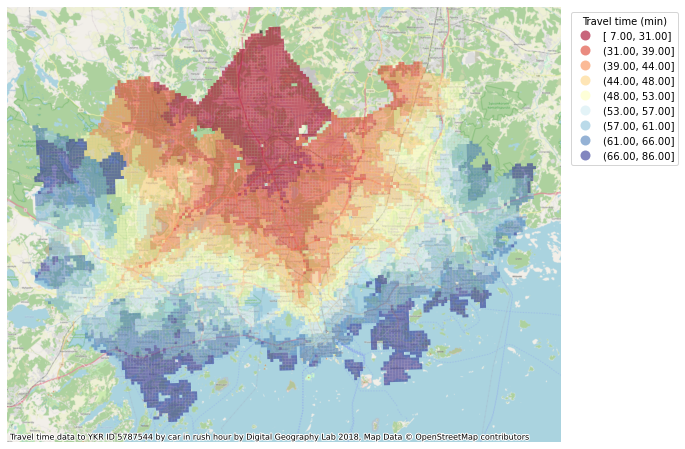

In [40]:
Visualizer(lista, "output_folder", "car", "static")

In [102]:
def ComparisonTool(tm_comp: list):
    
    assert type(tm_comp) == list, "The travel modes for comparison has to be passed as a list!"
    assert len(tm_comp) == 2, "Make sure there are only two travel modes to be compared!"
    
    tm1 = tm_comp[0]
    tm2 = tm_comp[1]
    
    
    
    
    
    
    return tm1, tm2
    

In [105]:
ComparisonTool("test")

AssertionError: The travel modes for comparison has to be passed as a list!

In [109]:
def FilepathFinder(file_name: str):
    """
    Finds a selected file's filepath from current directory. 

            Parameters:
                    file_name (str): Name of the file

            Returns:
                    None
    """
    # Defining flag
    flag = False
    # Getting current directory
    p = Path().absolute()
    # For-looping current directory
    for root, dirs, files in os.walk(p):
        for file in files:
            # Looking for the grid file
            if file == file_name:
                # Creating a filepath of the grid file
                fullpath = os.path.join(root, file)
                filepath = os.path.abspath(fullpath)
                # Changing flag value
                flag = True
    # Checking flag value
    if flag == False:
        # Raising an error
        raise OSError(f"File: {file_name} does not exist in current working directory!\n{p}")
    # Returning the grid's filepath
    return filepath



In [110]:
FilepathFinder(".txt", "travel_times_to_ 5990002.txt")

'C:\\Users\\zuzzuz\\Desktop\\PYQGIS_101\\AUTOGIS_PACKAGE\\final-assignment-pjustus\\TTM_files\\HelsinkiTravelTimeMatrix2018\\5990xxx\\travel_times_to_ 5990002.txt'